In [1]:
import csv
import pandas as pd
import os
import shutil
from scapy.all import rdpcap, IP, TCP, UDP
import numpy as np

from collections import defaultdict
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import load_model
import glob

from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
pio.templates.default = "plotly_dark"
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as ps

# Draw Flowpic from .npy

In [2]:
def plot_flowpic(flowpic, title):
    # Extract the histogram component from the FlowPic
    histogram = np.transpose(flowpic)

    # make color map
    my_cmap = colors.ListedColormap(['white', 'black'])
    my_norm = colors.BoundaryNorm([0, 0.000001, np.max(histogram)], my_cmap.N)

    # Plot the histogram using imshow
    plt.imshow(histogram, origin='lower', cmap = my_cmap, norm = my_norm, aspect='auto')
    plt.ylabel('Packet Size')
    plt.xlabel('Arrival Time')
    plt.title(title)
    cbar = plt.colorbar(label='Normalized Frequency', ticks=[0, np.max(histogram)], boundaries=[0, np.max(histogram)])
    cbar.ax.set_yticklabels(['0', '>0'])
    #plt.colorbar(label='Normalized Frequency', ticks=[0, 1], boundaries=[0, 1])
    plt.show()

In [20]:
def plot_flowpic_scale(flowpic, title):
    # Extract the histogram component from the FlowPic
    histogram = np.transpose(flowpic)
    
    # Plot the histogram using imshow
    plt.imshow(histogram, cmap='gray_r', vmin = 0, vmax = 5, origin='lower', aspect='auto')
    plt.ylabel('Packet Size')
    plt.xlabel('Arrival Time')
    plt.title(title)
    plt.colorbar(label='Normalized Frequency')
    plt.show()

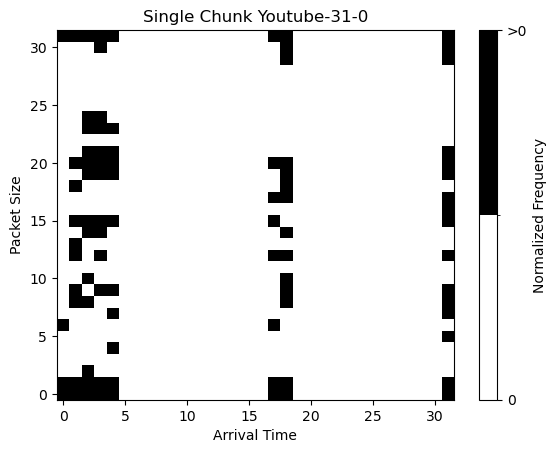

In [19]:
# Single chunk (first chunk of the session)
# Path to your .npy file
file_path = 'G:/features/first chunk/Youtube/Youtube-31-0.npy'

# Load the .npy file
matrix = np.load(file_path)

# Draw flowpic
plot_flowpic(matrix, title = "Single Chunk Youtube-31-0")

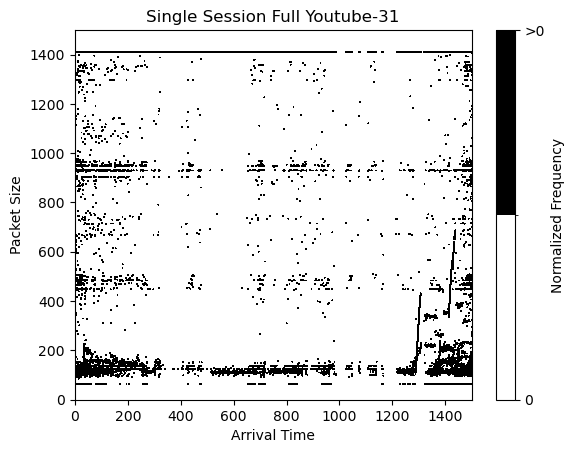

In [38]:
# Single session, all chunks
matrix = np.zeros((1500,1500))

folder_path = "G:/features/Youtube"

for filename in os.listdir(folder_path):
    if filename.startswith('Youtube-31'):
        file_path = os.path.join(folder_path, filename)
        # Load the .npy file and sum
        temp = np.load(file_path)
        matrix += temp

# Draw flowpic
plot_flowpic(matrix, title = "Single Session Full Youtube-31")

In [7]:
# All first chunks of the class

matrix = np.zeros((1500,1500))

folder_path = "G:/features/Youtube"

for filename in os.listdir(folder_path):
    if filename.endswith('0.npy'):
        file_path = os.path.join(folder_path, filename)
        # Load the .npy file and sum
        temp = np.load(file_path)
        matrix += temp

# Draw flowpic
plot_flowpic(matrix, title = "Full Class First Chunks- Youtube")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'G:/features/first chunks/Youtube'

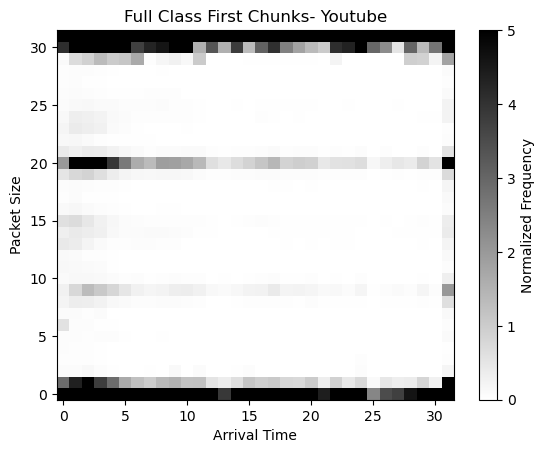

In [23]:
# All first chunks of the class - in grayscale

matrix = np.zeros((32,32)) #1500, 1500

folder_path = "G:/features/first chunk/Youtube"

for filename in os.listdir(folder_path):
    if filename.endswith('0.npy'):
        file_path = os.path.join(folder_path, filename)
        # Load the .npy file and sum
        temp = np.load(file_path)
        matrix += temp

# Draw flowpic
plot_flowpic_scale(matrix, title = "Full Class First Chunks- Youtube")

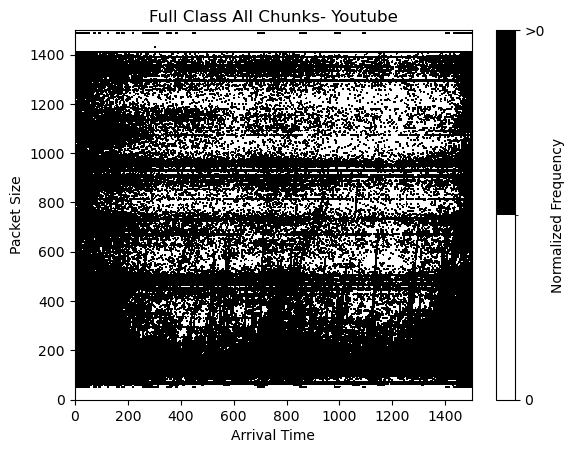

In [41]:
# All total chunks of the class

matrix = np.zeros((1500,1500))

folder_path = "G:/features/Youtube"

for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        # Load the .npy file and sum
        temp = np.load(file_path)
        matrix += temp

# Draw flowpic
plot_flowpic(matrix, "Full Class All Chunks- Youtube")

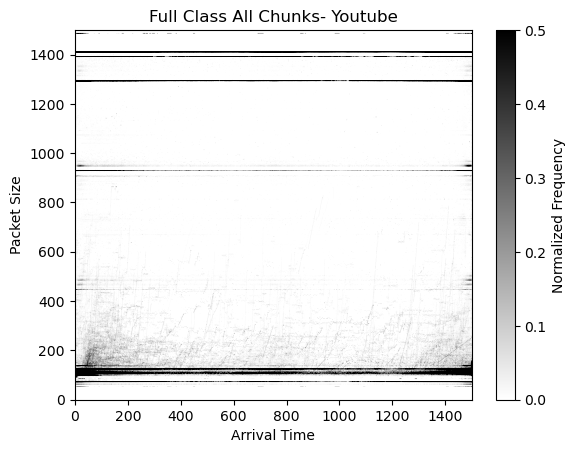

In [42]:
# All total chunks of the class - in grayscale

matrix = np.zeros((1500,1500))

folder_path = "G:/features/Youtube"

for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        # Load the .npy file and sum
        temp = np.load(file_path)
        matrix += temp

# Draw flowpic
plot_flowpic_scale(matrix, title = "Full Class All Chunks- Youtube")

# Create CSV from pcap

In [18]:
def compare_sessions(session1, session2):
    return (
        (session1['IP1'], session1['IP2'], session1['Port1'], session1['Port2']) == 
        (session2['IP2'], session2['IP1'], session2['Port2'], session2['Port1'])
    )

def process_csv(file_path, file_index):
    # קריאת קובץ ה-CSV
    data = pd.read_csv(file_path)

    # הנחות לגבי שמות העמודות בקובץ ה-CSV
    session_columns = ['IP1', 'IP2', 'Port1', 'Port2']
    grouped = data.groupby(session_columns)

    # Create a list to store the results
    results = []
    s_index = 0;
    
    # Iterate over each group
    for session_id, group in grouped:
        
        # Sort the group by packet time
        group = group.sort_values(by='packet_times')

        # Calculate the sum of packet sizes for the session
        total_packet_size = group['packet_sizes'].sum()

        # Calculate the time difference for the session
        time_difference = group['packet_times'].max() - group['packet_times'].min()

        # Append the result to the results list
        results.append({
            'IP1': session_id[0],
            'IP2': session_id[1],
            'Port1': session_id[2],
            'Port2': session_id[3],
            'total_packet_size': total_packet_size,
            'time_difference': time_difference,
            'file_index': file_index,
            'session_index': s_index,
            'direction': 0
        })
        
        #for _, group2 in grouped:
         #   if((group['IP1'] == group2['IP2']) && (group['IP2'] == group2['IP1']) && (group['Port1'] == group2['Port2'])
          #    && (group['Port2'] == group2['Port1']))       
        
        s_index+=1


    matching_pairs = []
    n = len(results)
    for i in range(n):
        for j in range(i + 1, n):
            if compare_sessions(results[i], results[j]):
                results[j]['session_index']= results[i]['session_index']
                results[j]['direction']= 1

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)
    
    return(results_df)

In [13]:
def create_df(directory_path):

    # קריאת כל הקבצים בתיקייה ועיבודם
    #directory_path = "Youtube"  # נתיב לתיקייה המכילה את קבצי ה-CSV
    # עם כיוונים
    all_sessions_dirs = pd.DataFrame()

    for file_index, filename in enumerate(os.listdir(directory_path), start=1):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory_path, filename)
            file_sessions_df = process_csv(file_path, file_index)
            # הוספת מספר הקובץ לכל עמודה שמייצגת מזהה סשן
            all_sessions_dirs = pd.concat([all_sessions_dirs, file_sessions_df], ignore_index=True)

    #print(all_sessions_dirs)
    # שמירת ה-DataFrame הסופי כקובץ CSV
    #all_sessions_df.to_csv('all_sessions.csv', index=False)
    
    return(all_sessions_dirs.sort_values(by=['file_index','session_index']))

In [10]:
def combine_dirs(df):
    #all_sessions = df.drop(['direction'])

    # Combine both directions of the same session
    combined_dirs = df.groupby(['file_index', 'session_index']).agg({
        'IP1': 'first',
        'IP2': 'first',
        'Port1': 'first',
        'Port2': 'first',
        'total_packet_size': 'sum',
        'time_difference': 'sum'
    }).reset_index()

    return(combined_dirs)

In [15]:
def stats_and_filter(df):
    print("Max time difference: ")
    print(df['time_difference'].max())
    print("Mean time difference: ")
    print(df['time_difference'].mean())
    print("Max packet size: ")
    print(df['total_packet_size'].max())
    print("Mean packet size: ")
    print(df['total_packet_size'].mean())

    filtered_df = df[df['time_difference'] > 10000]
    print("Count of sessions at least 10s long: ")
    print(len(filtered_df))
    
    return(filtered_df)

In [20]:
directory = "YouTube"

yt_directions = create_df(directory)
yt_sessions = combine_dirs(yt_directions)
yt_filtered = stats_and_filter(yt_sessions)

Max time difference: 
17040.582107067108
Mean time difference: 
94.26787502648948
Max packet size: 
52839817
Mean packet size: 
1717862.1704545454
Count of sessions at least 10s long: 
17


In [21]:
yt_filtered

,file_index,session_index,IP1,IP2,Port1,Port2,total_packet_size,time_difference
239,1,381,192.168.10.35,216.58.203.14,35579,443,3021349,15057.203760
607,3,396,192.168.10.35,216.58.203.14,35579,443,3273815,17040.582107
955,5,387,192.168.10.35,216.58.203.14,35579,443,3379606,16713.427907
1318,7,345,192.168.10.35,216.58.203.14,35579,443,3233913,16996.472005
1654,9,316,192.168.10.35,216.58.203.14,35579,443,3197368,16203.470386
1936,11,243,192.168.10.35,216.58.203.14,35579,443,2749398,15441.493135
2224,13,246,192.168.10.35,216.58.203.14,35579,443,2915051,15643.753843
2523,15,294,192.168.10.35,216.58.203.14,35579,443,2326075,11254.081425
2903,19,94,172.217.161.174,192.168.10.35,443,46054,2658080,12227.143988
3430,23,73,172.217.24.46,192.168.10.35,443,48355,2671734,14224.144297


In [19]:
directory = "FileTransfer"

ft_directions = create_df(directory)
ft_sessions = combine_dirs(ft_directions)
ft_filtered = stats_and_filter(ft_sessions)

Max time difference: 
10397.072749853134
Mean time difference: 
49.93873140615798
Max packet size: 
73510723
Mean packet size: 
688511.814271556
Count of sessions at least 10s long: 
2


In [22]:
ft_filtered

,file_index,session_index,IP1,IP2,Port1,Port2,total_packet_size,time_difference
1596,6,278,192.168.10.30,192.168.10.35,443,42008,1123138,10397.072750
1843,6,525,192.168.10.30,192.168.10.35,443,50491,934524,10105.667753


In [23]:
directory = "Google_PlayMusic"

music_directions = create_df(directory)
music_sessions = combine_dirs(music_directions)
music_filtered = stats_and_filter(music_sessions)

Max time difference: 
76934.34208083153
Mean time difference: 
71.54504351266644
Max packet size: 
16113218
Mean packet size: 
482580.88007976714
Count of sessions at least 10s long: 
25


In [24]:
music_filtered

,file_index,session_index,IP1,IP2,Port1,Port2,total_packet_size,time_difference
275,1,470,172.31.46.140,173.194.205.189,49789,443,154081,20266.570484
857,3,702,172.31.46.140,173.194.205.189,49789,443,216419,27269.135959
1315,5,210,172.217.13.78,172.31.1.227,443,62264,12593,21927.875738
1895,5,1502,172.31.1.227,209.85.232.189,53830,443,363772,47699.055820
2979,7,826,172.217.9.206,172.31.1.227,443,65416,32432,30591.056512
3042,7,1716,172.31.1.227,173.194.66.189,56232,443,305235,38322.917456
4076,9,1668,172.31.1.227,173.194.206.189,59928,443,327631,43353.472231
5367,11,1723,172.31.1.227,173.194.204.189,61960,443,392224,49750.624366
6169,13,657,172.31.46.140,173.194.205.189,49789,443,259277,27457.149024
6427,15,34,172.217.13.226,172.31.1.227,443,52443,18497,19279.634260


In [27]:
directory = "GoogleHangout_Chat"

chat_directions = create_df(directory)
chat_sessions = combine_dirs(chat_directions)
chat_filtered = stats_and_filter(chat_sessions)

Max time difference: 
47590.23502612114
Mean time difference: 
174.08022274875364
Max packet size: 
425164492
Mean packet size: 
199764.842196496
Count of sessions at least 10s long: 
33


In [28]:
chat_filtered

,file_index,session_index,IP1,IP2,Port1,Port2,total_packet_size,time_difference
1258,5,482,172.217.161.142,192.168.10.30,443,34935,37769,14771.021038
1286,5,510,172.217.161.142,192.168.10.30,443,37522,400693,22287.788141
1411,5,635,172.217.161.142,192.168.10.30,443,45083,10274,12603.259148
1432,5,656,172.217.161.142,192.168.10.30,443,46641,12385,14527.968936
1632,5,856,172.217.161.142,192.168.10.30,443,59193,38525,27551.571624
3475,10,249,172.217.25.14,192.168.0.107,443,48476,264372,26402.708824
4893,15,550,172.217.161.142,192.168.10.30,443,52573,25246,21850.586433
5529,16,481,172.217.25.14,192.168.10.30,443,39354,11344,33507.882008
5806,16,758,172.217.25.14,192.168.10.30,443,53867,37954,15413.127214
5811,16,763,172.217.25.14,192.168.10.30,443,53962,25442,22519.109619


In [29]:
directory = "GoogleHangout_VoIP"

voip_directions = create_df(directory)
voip_sessions = combine_dirs(voip_directions)
voip_filtered = stats_and_filter(voip_sessions)

Max time difference: 
222094.61428499222
Mean time difference: 
535.8913148091757
Max packet size: 
6787980
Mean packet size: 
34148.611891874265
Count of sessions at least 10s long: 
643


In [31]:
voip_filtered

,file_index,session_index,IP1,IP2,Port1,Port2,total_packet_size,time_difference
0,1,0,0.0.0.0,255.255.255.255,68,67,20943,45882.891130
87,1,87,108.177.97.189,192.168.0.103,443,39231,56313,16253.252835
465,1,465,169.254.3.252,224.0.0.251,5353,5353,48651,47268.375420
669,1,669,172.217.161.161,192.168.0.103,443,54982,16084,42095.023664
725,1,725,172.217.161.163,192.168.0.103,443,34110,26215,34944.083246
...,...,...,...,...,...,...,...,...
61321,35,2666,192.168.4.7,224.0.0.251,5353,5353,16189,67362.423707
61324,35,2669,192.168.4.74,224.0.0.251,5353,5353,60718,63286.138082
61325,35,2670,192.168.4.75,224.0.0.251,5353,5353,2880,61201.580942
61327,35,2672,192.168.4.82,224.0.0.251,5353,5353,12480,63663.299171


# Quic Text Dataset

In [12]:
def txt_to_csv(txt_file_path, csv_file_path):

    # Determine the delimiter, in this case, it's a space
    delimiter = '\t'
            
    custom_headers = ['Timestamp', 'Relative time', 'Packet size', 'Packet direction']

    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()

    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        # Write custom headers
        csv_writer.writerow(custom_headers)
        # Write data rows
        for line in lines:
            csv_writer.writerow(line.strip().split(delimiter))


In [20]:
folder_path = 'dataset-text/Youtube'

for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            txt_file_path = os.path.join(folder_path, filename)
            csv_file_path = os.path.join(folder_path, filename.replace('.txt', '.csv'))
            txt_to_csv(txt_file_path, csv_file_path)

In [13]:
#txt_to_csv("dataset-text/Google Doc/GoogleDoc-100.txt", "dataset-text/Google Doc/GoogleDoc-100.csv")

In [21]:
csv_file_path = "dataset-text/Google Doc/GoogleDoc-100.csv"
data = pd.read_csv(csv_file_path)
data

,Timestamp,Relative time,Packet size,Packet direction
0,1.527993e+09,0.000000,354,1
1,1.527993e+09,0.032811,87,0
2,1.527993e+09,0.261392,323,0
3,1.527993e+09,0.262656,1412,0
4,1.527993e+09,0.263943,1412,0
...,...,...,...,...
2920,1.527994e+09,116.182000,258,1
2921,1.527994e+09,116.214000,389,1
2922,1.527994e+09,116.215000,87,0
2923,1.527994e+09,116.235000,87,0


In [49]:
def count_csv(folder_path):
    total = 0
    count = 0
    largest_time = 0
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            #print(filename)
            total += 1
            file_path = os.path.join(folder_path, filename)
            # קריאת קובץ ה-CSV
            data = pd.read_csv(file_path)
            last_relative_time = data['Relative time'].iloc[-1]
            #print(last_relative_time)
            if last_relative_time > largest_time:
                largest_time = last_relative_time
            # if relative time is miliseconds
            if last_relative_time >= 15:
                count += 1
    
    return total, count, largest_time
    

In [56]:
print(count_csv('dataset-text/Youtube'))

(1077, 1072, 63.4592)


In [31]:
print(count_csv("dataset-text/Google Doc/GoogleDoc-100.csv"))

116.348
(1, 1)


In [9]:
def chunk(file_path, chunk_length='15s'):
    """
    Returns a list of DataFrames, each `chunk_length` long in duration.
    """
    empty_chunks = 0
    
    df = pd.read_csv(file_path)
    
    if df.empty:
        print(f"No data found in {file_path}")
        return
    
    df_time = df.assign(dt_timestamp=pd.to_datetime(df['Relative time'], unit='s'))

    # Important that we specify `origin='start'`, otherwise specifying a minute
    # will create chunks at e.g. 5:01, 5:02, ..., when we want to just take
    # 60s from the very first observation
    resampled = df_time.resample(chunk_length, on='dt_timestamp', origin='start')

    chunks = []

    # Debugging: Print the resampled object
    #print("Resampled object:")
    for (dt_timestamp, frame) in resampled:
        chunks.append(frame)

    # Get rid of last chunk if it's incomplete
    last = chunks[-1]
    if last.dt_timestamp.max() - last.dt_timestamp.min() < pd.Timedelta(chunk_length):
        chunks.pop()
        
    for i, chunk in enumerate(chunks):
        if chunk.empty:
            print(f"Chunk {i} is empty, skipping...")
            empty_chunks += 1
            continue
        chunk[['Timestamp', 'Packet size']].to_csv(
            os.path.join('dataset-text/chunks', filename.replace('.csv', f'-{i}.csv'))#f'{prefix}-{i}-{fname}')
        )
    
    print(f'num of empty chunks in {file_path} is {empty_chunks}')

    #return chunks

In [5]:
data = pd.read_csv("dataset-text/Google Doc/GoogleDoc-100.csv")
chunks = chunk(data, '15s')
print(chunks)

Resampled object:
[        Timestamp  Relative time  Packet size  Packet direction  \
0    1.527993e+09       0.000000          354                 1   
1    1.527993e+09       0.032811           87                 0   
2    1.527993e+09       0.261392          323                 0   
3    1.527993e+09       0.262656         1412                 0   
4    1.527993e+09       0.263943         1412                 0   
..            ...            ...          ...               ...   
505  1.527994e+09      14.800900          309                 0   
506  1.527994e+09      14.802300          101                 1   
507  1.527994e+09      14.946600          388                 1   
508  1.527994e+09      14.946700          255                 1   
509  1.527994e+09      14.964500           87                 0   

                     dt_timestamp  
0   2018-06-03 02:38:15.652867079  
1   2018-06-03 02:38:15.685678005  
2   2018-06-03 02:38:15.914258957  
3   2018-06-03 02:38:15.91552305

[308 rows x 5 columns]]


In [14]:
folder_path = "dataset-text/Google Doc"

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        #print(filename)
        file_path = os.path.join(folder_path, filename)
        # קריאת קובץ ה-CSV
        #data = pd.read_csv(file_path)
        chunk(file_path, '15s')
        '''chunks = chunk(data, '15s')
        for i, chunk in enumerate(chunks):
            chunk[['Timestamp', 'Packet size']].to_csv(
                os.path.join('dataset-text/Youtube/chunks', filename.replace('.csv', f'-{i}.csv'))#f'{prefix}-{i}-{fname}')
            )'''

num of empty chunks in dataset-text/Google Doc\GoogleDoc-100.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1000.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1001.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1002.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1003.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1004.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1005.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1006.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1007.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1008.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1009.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-101.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1010.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1011.csv is 0
num of e

num of empty chunks in dataset-text/Google Doc\GoogleDoc-1207.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1208.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1209.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-121.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1210.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1211.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1212.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1213.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1214.csv is 0
Chunk 4 is empty, skipping...
Chunk 5 is empty, skipping...
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1215.csv is 2
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1216.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1217.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-1218.csv is 0
num of empty chunk

num of empty chunks in dataset-text/Google Doc\GoogleDoc-305.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-306.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-307.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-308.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-309.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-31.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-310.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-311.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-312.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-313.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-314.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-315.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-316.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-317.csv is 0
num of empty chunks i

num of empty chunks in dataset-text/Google Doc\GoogleDoc-515.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-516.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-517.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-518.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-519.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-52.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-520.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-521.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-522.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-523.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-524.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-525.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-526.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-527.csv is 0
num of empty chunks i

num of empty chunks in dataset-text/Google Doc\GoogleDoc-726.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-727.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-728.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-729.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-73.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-730.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-731.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-732.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-733.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-734.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-735.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-736.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-737.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-738.csv is 0
num of empty chunks i

num of empty chunks in dataset-text/Google Doc\GoogleDoc-937.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-938.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-939.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-94.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-940.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-941.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-942.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-943.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-944.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-945.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-946.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-947.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-948.csv is 0
num of empty chunks in dataset-text/Google Doc\GoogleDoc-949.csv is 0
num of empty chunks i

In [15]:
docs_count = 0
drive_count = 0
music_count = 0
yt_count = 0

search_count = 0

for filename in os.listdir('dataset-text/chunks'):
    if filename.startswith('GoogleDoc'):
        docs_count+=1
    elif filename.startswith('GoogleDrive'):
        drive_count+=1
    elif filename.startswith('GoogleMusic'):
        music_count+=1
    elif filename.startswith('GoogleSearch'):
        search_count+=1
    elif filename.startswith('Youtube'):
        yt_count +=1
    else:
        print("other file")
        
print("docs count = " + f'{docs_count}')
print("drive count = " + f'{drive_count}')
print("music count = " + f'{music_count}')
print("search count = " + f'{search_count}')
print("yt count = " + f'{yt_count}')

docs count = 8421
drive count = 2413
music count = 0
search count = 0
yt count = 3543


In [6]:
csv_file_path = "data/preprocessed/GoogleDoc-1051-6.csv"
data = pd.read_csv(csv_file_path)
data

,Unnamed: 0,Timestamp,Packet size


In [5]:
csv_file_path = "data/preprocessed/GoogleDoc-1051-5.csv"
data = pd.read_csv(csv_file_path)
data

,Unnamed: 0,Timestamp,Packet size
